Por Pablo Fornet Martín
Basado en el código de https://num.pyro.ai/en/stable/examples/bnn.html

In [1]:
import argparse
import os
import time
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [2]:
# the non-linearity we use in our neural network
def nonlin(x):
    return jnp.tanh(x)


In [3]:
def model(X, Y, D_H, D_Y=10):
  N, D_X = X.shape

  # sample first layer (we put unit normal priors on all weights)
  w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
  assert w1.shape == (D_X, D_H)
  z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations
  assert z1.shape == (N, D_H)

  # sample second layer
  w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
  assert w2.shape == (D_H, D_Y)
  # z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations
  z2 = jnp.matmul(z1, w2)
  assert z2.shape == (N, D_Y)

  # sample final layer of weights and neural network output
  # w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
  # assert w3.shape == (D_H, D_Y)
  # z3 = jnp.matmul(z2, w3)  # <= output of the neural network
  # assert z3.shape == (N, D_Y)

  distribution = jnp.exp(z2) / jnp.sum(jnp.exp(z2), axis=1, keepdims=True)


  # observe data
  with numpyro.plate("data", N):
    numpyro.sample("Y", dist.CategoricalProbs(distribution), obs=Y)

In [4]:
# helper function for HMC inference
def run_inference(model, num_warmups, num_sample, num_chain, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmups,
        num_samples=num_sample,
        num_chains=num_chain,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

In [5]:
# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace["Y"]["value"]

In [6]:
def loadDataset(fileName, samples):
  x = []  # Array for data inputs
  y = []  # Array for labels (expected outputs)

  # Load data from a CSV file and store it in a pandas DataFrame object
  with open(fileName, 'r') as f:
      train_data = pd.read_csv(f)

  # Extract labels from the first column of the DataFrame object
  y = jnp.array(train_data.iloc[0:samples, 0])

  # Extract data from the remaining columns of the DataFrame object and normalize it
  x = jnp.array(train_data.iloc[0:samples, 1:]) / 255

  return x, y

In [7]:
# Define the number of training and testing samples
trainingSamples = 20000
testingSamples = 10000

D_H = 50
num_warmup = 100
num_samples = 1000
num_chains = 1

numpyro.set_platform("cpu")
numpyro.set_host_device_count(num_chains)

In [8]:
# Load the training and testing datasets
train_x, train_y = loadDataset('MNIST/mnist_train_small.csv', trainingSamples)
test_x, test_y = loadDataset('MNIST/mnist_test.csv', testingSamples)

In [9]:
noNineTrain_x = train_x[train_y != 9]
noNineTrain_y = train_y[train_y != 9]

In [10]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(int(time.time())))
samples = run_inference(model, num_warmup, num_samples, num_chains, rng_key, noNineTrain_x, noNineTrain_y, D_H)

sample: 100%|██████████| 1100/1100 [6:08:48<00:00, 20.12s/it, 511 steps of size 1.02e-02. acc. prob=0.88]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   w1[0,0]     -0.05      1.01     -0.00     -1.64      1.62    708.77      1.00
   w1[0,1]      0.02      0.99      0.00     -1.53      1.62   1161.09      1.00
   w1[0,2]      0.04      0.99      0.04     -1.47      1.75    659.80      1.00
   w1[0,3]      0.05      0.96      0.05     -1.57      1.67   1358.81      1.00
   w1[0,4]     -0.00      1.02     -0.04     -1.52      1.82   1317.66      1.00
   w1[0,5]      0.04      1.06     -0.03     -1.71      1.72    222.96      1.00
   w1[0,6]     -0.01      0.98     -0.07     -1.65      1.43    952.17      1.00
   w1[0,7]     -0.00      0.98     -0.00     -1.79      1.44   1075.59      1.00
   w1[0,8]      0.03      0.92      0.01     -1.37      1.60   1034.25      1.00
   w1[0,9]     -0.03      1.03     -0.01     -1.61      1.80   1095.35      1.00
  w1[0,10]     -0.04      0.97     -0.10     -1.46      1.51   1114.85      1.00
  w1[0,11]     -0.05      0

In [11]:
# %store samples30
%store samples

Stored 'samples' (dict)


In [12]:
# %store -r samples

C:\Users\forne\AppData\Local\Temp\ipykernel_34280\1141717600.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples["w2"][:, 50, i], ax=ax)
C:\Users\forne\AppData\Local\Temp\ipykernel_34280\1141717600.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples["w2"][:, 50, i], ax=ax)
C:\Use

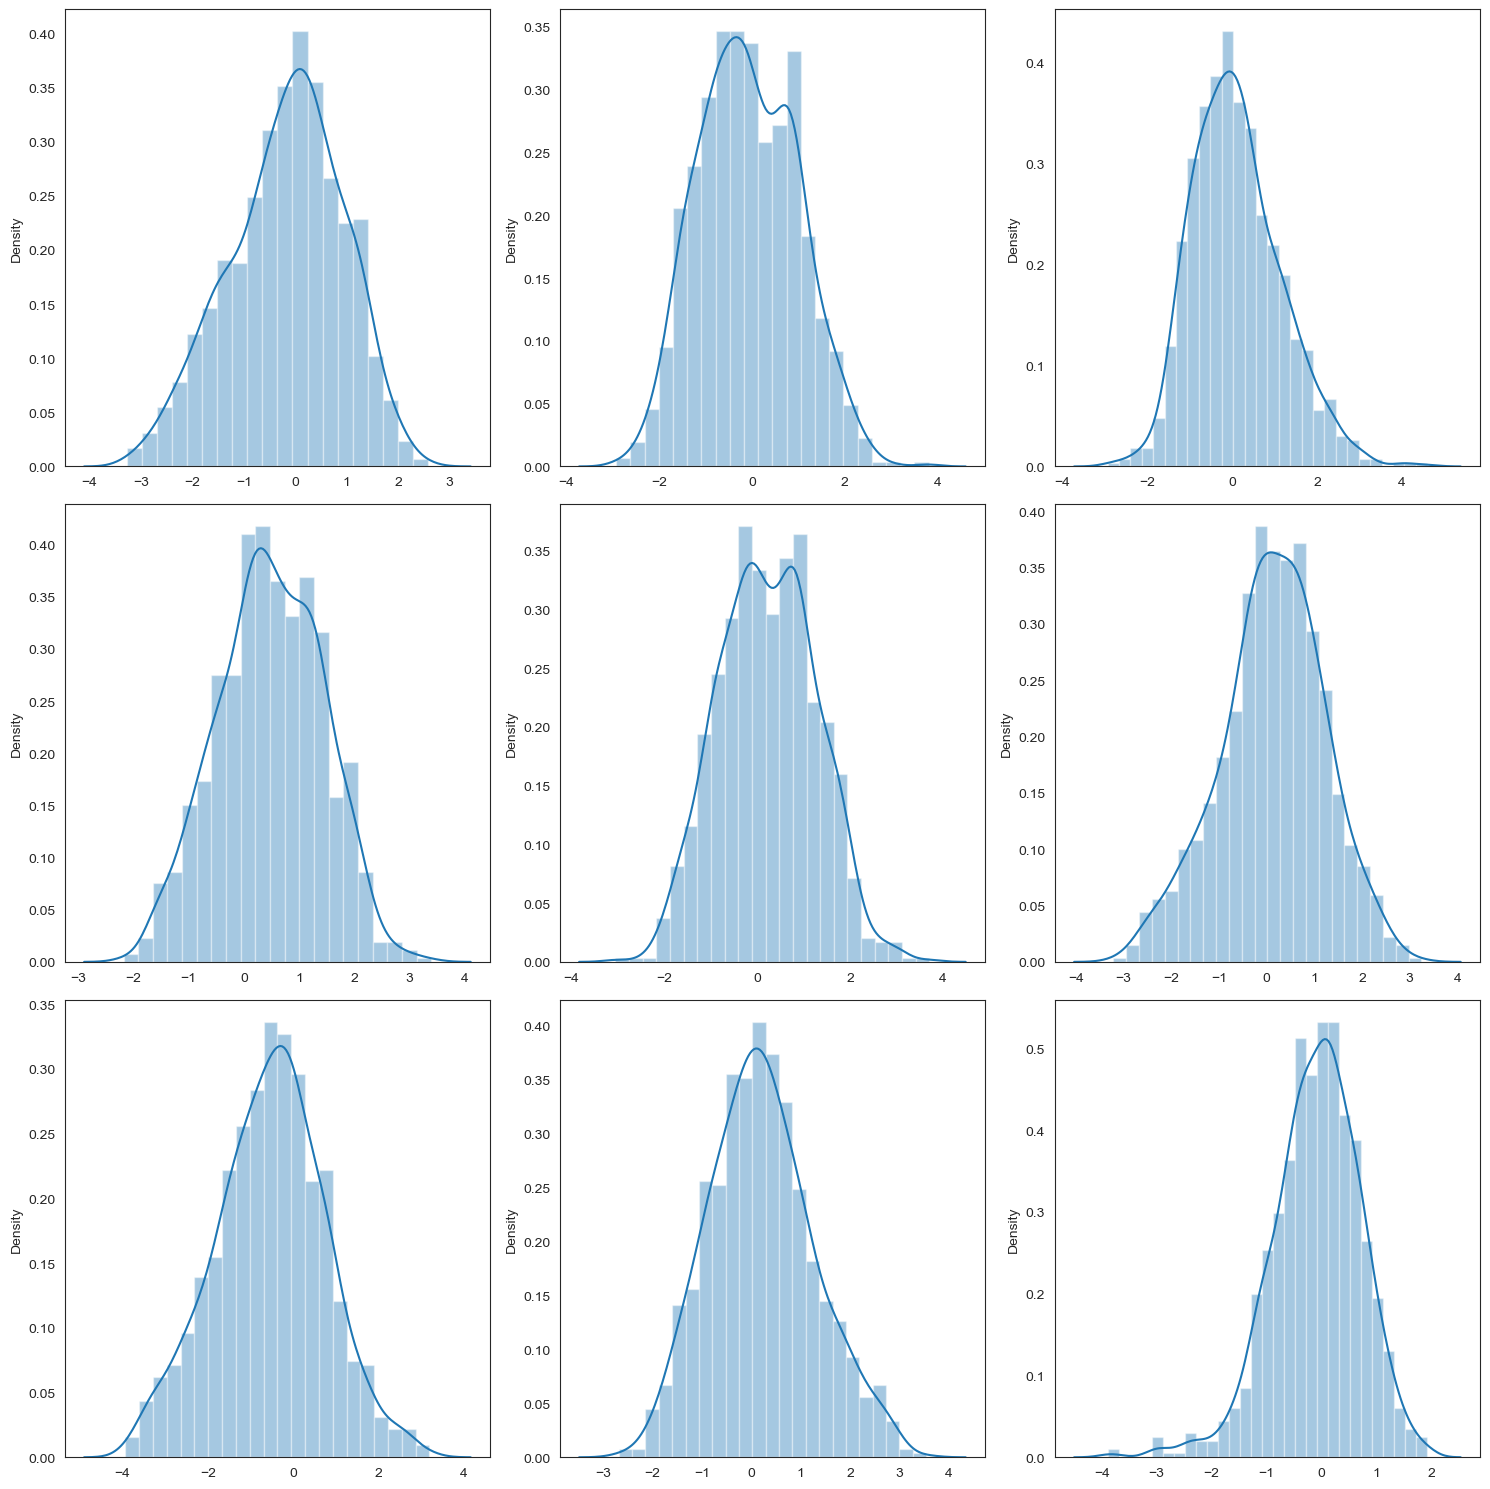

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(ax.reshape(-1)):
    sns.distplot(samples["w2"][:, 50, i], ax=ax)
plt.tight_layout()

plt.savefig('Imagenes/MCMC-weights2.pdf')

In [14]:
print(samples["w1"][:, 0, 0].shape)

(1000,)


In [15]:
print(samples["w1"].shape)

(1000, 784, 50)


In [16]:
# predict test_y at inputs test_x
vmap_args = (
    samples,
    random.split(rng_key_predict, num_samples * num_chains),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, test_x, D_H)
)(*vmap_args)
predictions1 = predictions[..., 0]

In [17]:
output = np.zeros((len(test_y), 10))
for j in range(10):
  output[:, j] = np.sum(predictions == j, axis=0)

output = output/num_samples
_, result = torch.max(torch.tensor(output), 1)

In [18]:
validResults = 0
certainty_distribution = np.zeros(len(test_y))
wrong_certainty_distribution = []
correct_certainty_distribution = []
predictions_matrix = np.zeros((10, 10))
nine_certainty_distribution = []

for i in range(len(test_y)):
  certainty = output[i][result[i].item()]
  certainty_distribution[i] = certainty
  predictions_matrix[test_y[i]][result[i].item()] += 1
  if test_y[i] == result[i].item():
    outcome = "OK"
    validResults += 1
    correct_certainty_distribution.append(certainty)
  else:
    outcome = "Fail"
    wrong_certainty_distribution.append(certainty)
  if test_y[i] == 9:
    nine_certainty_distribution.append(certainty)

  print("Nº ", i + 1, " | Expected result: ", test_y[i], " | Obtained result: ", result[i].item(), " | ", outcome,
        " | Certainty: ", round(certainty, 3),
        "%")

# Calculate and print out the training and testing time and the testing accuracy
print("-------------------------------")
print("Results")
print("-------------------------------")
print("Training samples: ", trainingSamples)
# print("Training time: ", round(trainingTime, 2), " s")
print("Testing samples: ", testingSamples)
# print("Testing time: ", round(testingTime, 2), " s")
print("Testing accuracy: ", round((validResults / testingSamples) * 100, 2), "%")


Nº  1  | Expected result:  7  | Obtained result:  7  |  OK  | Certainty:  0.999 %
Nº  2  | Expected result:  2  | Obtained result:  2  |  OK  | Certainty:  0.981 %
Nº  3  | Expected result:  1  | Obtained result:  1  |  OK  | Certainty:  0.999 %
Nº  4  | Expected result:  0  | Obtained result:  0  |  OK  | Certainty:  0.992 %
Nº  5  | Expected result:  4  | Obtained result:  4  |  OK  | Certainty:  0.996 %
Nº  6  | Expected result:  1  | Obtained result:  1  |  OK  | Certainty:  1.0 %
Nº  7  | Expected result:  4  | Obtained result:  4  |  OK  | Certainty:  0.94 %
Nº  8  | Expected result:  9  | Obtained result:  3  |  Fail  | Certainty:  0.455 %
Nº  9  | Expected result:  5  | Obtained result:  6  |  Fail  | Certainty:  0.786 %
Nº  10  | Expected result:  9  | Obtained result:  4  |  Fail  | Certainty:  0.621 %
Nº  11  | Expected result:  0  | Obtained result:  0  |  OK  | Certainty:  0.996 %
Nº  12  | Expected result:  6  | Obtained result:  6  |  OK  | Certainty:  0.958 %
Nº  13  | 

In [28]:
predictions_matrix_mcmc = predictions_matrix
%store predictions_matrix_mcmc

Stored 'predictions_matrix_mcmc' (ndarray)


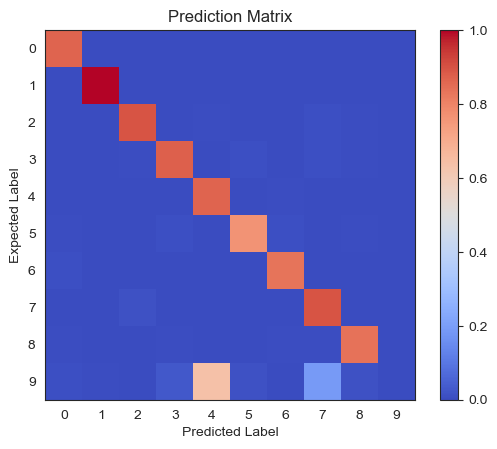

In [21]:
sns.set_style("white")
plt.title("Prediction Matrix")
plt.imshow(predictions_matrix/np.max(predictions_matrix), cmap='coolwarm')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("Expected Label")
plt.savefig("prediction_matrix.pdf")

C:\Users\forne\AppData\Local\Temp\ipykernel_34280\3329915564.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distributions[i], ax=ax)
C:\Users\forne\AppData\Local\Temp\ipykernel_34280\3329915564.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distributions[i], ax=ax)
C:\Users\forne\AppDa

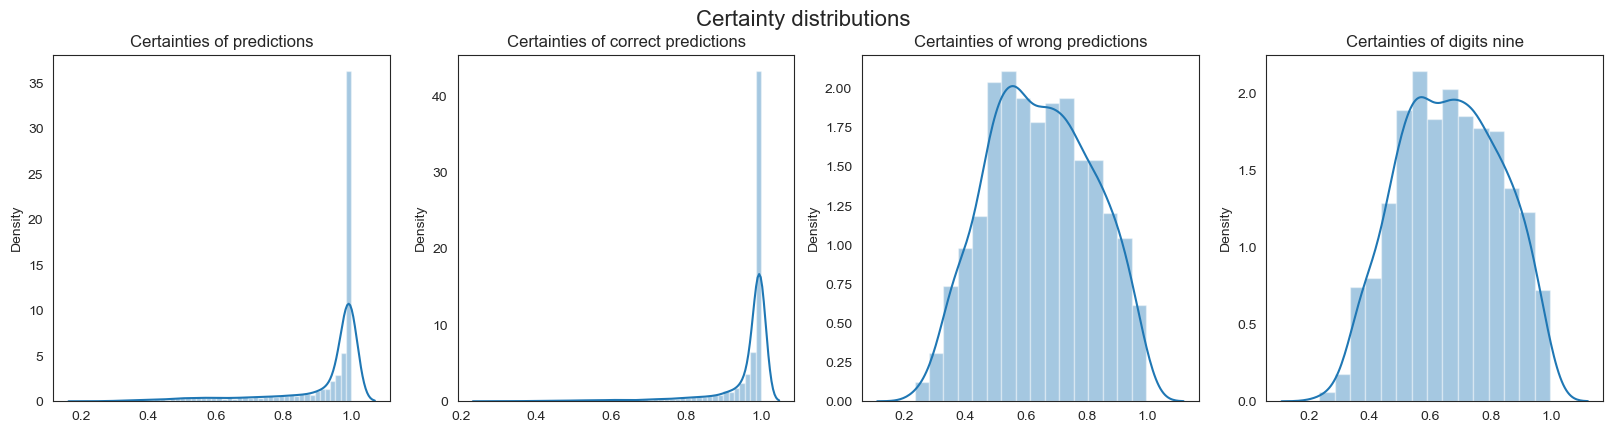

In [26]:
distributions_mcmc = [certainty_distribution, correct_certainty_distribution, wrong_certainty_distribution, nine_certainty_distribution]
titles = ["Certainties of predictions", "Certainties of correct predictions","Certainties of wrong predictions", "Certainties of digits nine"]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4.5))
fig.suptitle("Certainty distributions", fontsize=16)

for i, ax in enumerate(ax.flatten()):
    sns.distplot(distributions_mcmc[i], ax=ax)
    ax.set_title(titles[i])

# plt.savefig("certainty_distributions_mcmc.pdf")

In [27]:
%store distributions_mcmc

Stored 'distributions_mcmc' (list)
